In [1]:
from data import wiki
from data import corpus
import alignment

import nltk
import pandas as pd
import numpy as np
import pickle

from tqdm import tqdm_notebook as tqdm
from IPython.display import display, clear_output

import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline

tqdm().pandas()

markers = alignment.load_markers()
markers_list = ['quantifiers', 'impersonal_pronouns','adverbs', 
    'articles', 'auxiliary_verbs', 'conjunctions',  
    'personal_pronouns', 'prepositions']

posts = wiki.load_posts()
posts = corpus.tokenize_posts(posts, lower_case=True, overwrite=False)
posts = corpus.detect_markers(posts, markers, overwrite=False)

pairs = corpus.get_reply_pairs(posts)
users = wiki.load_users(posts=posts)

wiki.save_posts(posts, overwrite=False)
wiki.save_users(users, overwrite=False)

/Users/xnobwi/ShareFile/Personal Folders/Research/LASN/lasn/data/corpus.py:18: UserWarning: Posts are already tokenized. Skipping tokenization.
  warnings.warn("Posts are already tokenized. Skipping tokenization.")
/Users/xnobwi/ShareFile/Personal Folders/Research/LASN/lasn/data/corpus.py:64: UserWarning: All marker columns already exist. Skipping marker detection.
  warnings.warn("All marker columns already exist. Skipping marker detection.")
/Users/xnobwi/ShareFile/Personal Folders/Research/LASN/lasn/data/wiki.py:68: UserWarning: /Users/xnobwi/ShareFile/Personal Folders/Research/LASN/lasn/data/wiki/posts_df.pickle already exists. Not overwriting.
  warnings.warn("{} already exists. Not overwriting.".format(filename))
/Users/xnobwi/ShareFile/Personal Folders/Research/LASN/lasn/data/wiki.py:131: UserWarning: /Users/xnobwi/ShareFile/Personal Folders/Research/LASN/lasn/data/wiki/users_df.pickle already exists. Not overwriting.
  warnings.warn("{} already exists. Not overwriting.".format(

# Subtractive Conditional Probability (SCP)

Echoes of Power: given a set of exchanges $(u_a, u_b) \in U_{(A,b)}$ of user $b$ replying to users in group $A$, we define the coordination of $b$ _towards_ $A$ as:
$$
C^m(b,A) = P[\mathcal{E}_m(u_b) \mid \mathcal{E}_m(u_a)] - P[\mathcal{E}_m(u_b)]
$$

where $\mathcal{E}_m(u)$ means is $\mathtt{true}$ iff utterance $u$ exhibits marker $m$.

We estimate the probabilities as follows:
$$
\begin{align*}
P[\mathcal{E}_m(u_b)] &\approx \frac{|\{\mathcal{E}_m(u_b) \mid (u_a, u_b) \in {U_{(A,b)}}\}|}{|U_{A,b}|}\\
P[\mathcal{E}_m(u_b) \mid \mathcal{E}_m(u_a)] &\approx \frac{|\{\mathcal{E}_m(u_a)\land\mathcal{E}_m(u_b) \mid (u_a, u_b) \in {U_{(A,b)}}\}|}{|\{\mathcal{E}_m(u_a) \mid (u_a, u_b) \in {U_{(A,b)}}\}|}
\end{align*}
$$

In [2]:
posts['length'] = posts.tokens.apply(len)

# binarize centrality
threshold = users.centrality.mean() + users.centrality.std()
users['highly_central'] = (users['centrality'] > threshold)
print("Threshold centrality: {}".format(threshold))

# combine posts and user info
df = posts.merge(users, left_on='user', right_index=True)
# merge posts into reply pairs
df = df.merge(df, left_index=True, right_on='reply_to', suffixes=('_a', '_b'))

Threshold centrality: 0.8344793851197967


In [3]:
from alignment import scp, plot_scp

Compute SCP, comparing admin/non-admin targes and high-centrality/not targets.

In [4]:
admin_scp = scp(df, 'admin')
central_scp = scp(df, 'highly_central')

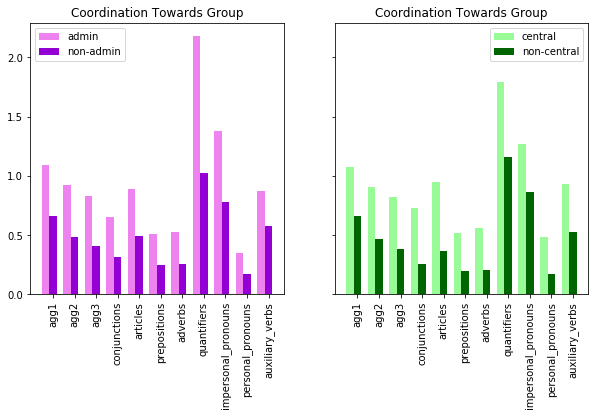

In [5]:
data = (admin_scp, central_scp)
labels = (['admin', 'non-admin'], ['central', 'non-central'])
colors = (['violet', 'darkviolet'], ['palegreen', 'darkgreen'])

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))

for ax, d, l, c in zip(axs, data, labels, colors):
    plot_scp(d, l, ax, c)
        


# Word-based SCP (WSCP)

Word-based SCP is similar to SCP, but instead of
comparing the probability of $u_b$ exhibiting $m$,
we compare the probability that a given word $w$ in
$u_b$ is in $m$ (the set of words constituting the marker).

Coordination of user $b$ towards group $A$ is defined:
$$
C^m(b,A) = P[w_b \in m \mid \mathcal{E}_m(u_a)] - P[w_b\in m]
$$

Where $P[w_b \in m \mid \mathcal{E}_m(u_a)]$ is estimated by the frequency of $m$ tokens over all posts in $\{(u_a,u_b)\in U_{(a,b)}\mid \mathcal{E}_m(u_a)\}$

And $P[w_b \in m]$ is estimated by the frequency of $m$ tokens in all posts by $b$ (not just those in $U_{a,b}$).

In [6]:
from alignment import wscp

In [7]:
admin_wscp = wscp(posts, df, 'admin')
central_wscp = wscp(posts, df, 'highly_central')

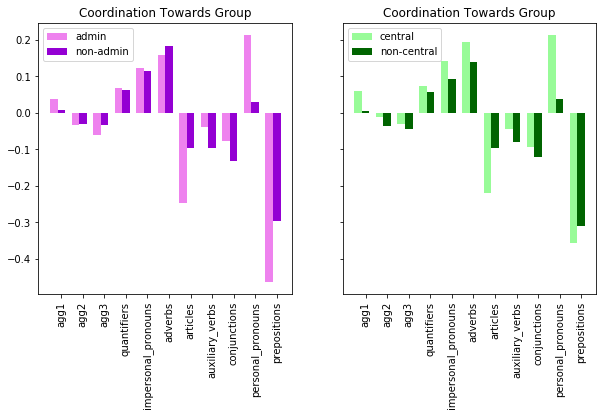

In [8]:
data = (admin_wscp, central_wscp)
labels = (['admin', 'non-admin'], ['central', 'non-central'])
colors = (['violet', 'darkviolet'], ['palegreen', 'darkgreen'])
groups = [True, False]
title = 'Coordination Towards Group'
items = ['agg1', 'agg2', 'agg3'] + markers_list

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
ind = np.arange(len(items))
width = 0.35

for ax, d, l, c in zip(axs, data, labels, colors):
    p = []
    for i, group in enumerate(groups):
        values = [d.mean(level=0).loc[group].loc[m] * 100 for m in items]
        p.append(ax.bar(ind+i*width, list(values), width=width, color=c[i]))
    ax.legend((p[i][0] for i in range(len(p))), l)
    ax.set_title(title)
    ax.set_xticklabels(items)
    ax.set_xticks(ind+width)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

# Correlation with centrality

How much does a user's centrality correlate with their degree of style coordination with different groups?


## SCP

In [9]:
print("Correlation between SCP coordination given & centrality")
for admin in(True, False):
    print("Coordination given to {}admins".format('' if admin else "non-"))
    print(20*" " +"{:6}   {:6}".format("r", "p-value"))
    a = admin_scp.loc[admin]
    a['centrality'] = users['centrality']
    for m in markers_list + ['agg1', 'agg2', 'agg3']:
        b = a[['centrality', m]].dropna()
        r, p_value = stats.pearsonr(b['centrality'], b[m])
        print("{:20}{:.5f}  {:.5f}".format(m,r, p_value))
    print()

Correlation between SCP coordination given & centrality
Coordination given to admins
                    r        p-value
quantifiers         0.04149  0.00022
impersonal_pronouns 0.02912  0.00973
adverbs             0.04793  0.00001
articles            0.02445  0.02813
auxiliary_verbs     0.03248  0.01055
conjunctions        0.05119  0.00001
personal_pronouns   0.03419  0.00209
prepositions        0.05226  0.00000
agg1                0.07086  0.00000
agg2                0.06943  0.00000
agg3                0.07659  0.00000

Coordination given to non-admins
                    r        p-value
quantifiers         0.03076  0.00046
impersonal_pronouns 0.03901  0.00001
adverbs             0.02228  0.00995
articles            0.01411  0.10582
auxiliary_verbs     0.05493  0.00000
conjunctions        0.05165  0.00000
personal_pronouns   0.02888  0.00089
prepositions        0.03777  0.00001
agg1                0.07804  0.00000
agg2                0.06405  0.00000
agg3                0.06963  0

In [10]:
print("Correlation between SCP coordination given & centrality")
for central in(True, False):
    print("Coordination given to {}central users".format('' if central else "non-"))
    print(20*" " +"{:6}   {:6}".format("r", "p-value"))
    a = central_scp.loc[central]
    a['centrality'] = users['centrality']
    for m in markers_list + ['agg1', 'agg2', 'agg3']:
        b = a[['centrality', m]].dropna()
        r, p_value = stats.pearsonr(b['centrality'], b[m])
        print("{:20}{:.5f}  {:.5f}".format(m,r, p_value))
    print()

Correlation between SCP coordination given & centrality
Coordination given to central users
                    r        p-value
quantifiers         0.04170  0.00008
impersonal_pronouns 0.04045  0.00015
adverbs             0.04306  0.00003
articles            0.02741  0.00914
auxiliary_verbs     0.03553  0.00297
conjunctions        0.05774  0.00000
personal_pronouns   0.01922  0.06567
prepositions        0.03926  0.00018
agg1                0.06628  0.00000
agg2                0.06868  0.00000
agg3                0.07640  0.00000

Coordination given to non-central users
                    r        p-value
quantifiers         0.03258  0.00029
impersonal_pronouns 0.03157  0.00049
adverbs             0.02064  0.01985
articles            0.01403  0.11658
auxiliary_verbs     0.05734  0.00000
conjunctions        0.05696  0.00000
personal_pronouns   0.02970  0.00087
prepositions        0.04418  0.00000
agg1                0.08008  0.00000
agg2                0.06725  0.00000
agg3            

## WSCP

In [11]:
print("Correlation between WSCP coordination given & centrality")
for admin in(True, False):
    print("Coordination given to {}admins".format('' if admin else "non-"))
    print(20*" " +"{:6}   {:6}".format("r", "p-value"))
    a = admin_wscp.loc[admin]
    a['centrality'] = users['centrality']
    for m in markers_list + ['agg1', 'agg2', 'agg3']:
        b = a[['centrality', m]].dropna()
        r, p_value = stats.pearsonr(b['centrality'], b[m])
        print("{:20}{:.5f}  {:.5f}".format(m,r, p_value))
    print()

Correlation between WSCP coordination given & centrality
Coordination given to admins
                    r        p-value
quantifiers         0.02156  0.05464
impersonal_pronouns 0.02444  0.03001
adverbs             0.02674  0.01514
articles            0.02937  0.00836
auxiliary_verbs     0.03178  0.01234
conjunctions        0.00482  0.67519
personal_pronouns   0.00223  0.84093
prepositions        0.05382  0.00000
agg1                0.05792  0.00001
agg2                0.05354  0.00000
agg3                0.05000  0.00000

Coordination given to non-admins
                    r        p-value
quantifiers         0.01078  0.21968
impersonal_pronouns 0.01704  0.05373
adverbs             0.01663  0.05445
articles            0.02455  0.00489
auxiliary_verbs     0.02017  0.03926
conjunctions        -0.00404  0.65260
personal_pronouns   0.01129  0.19436
prepositions        0.00392  0.65319
agg1                0.04369  0.00002
agg2                0.02754  0.00124
agg3                0.02035 

In [12]:
print("Correlation between WSCP coordination given & centrality")
for central in(True, False):
    print("Coordination given to {}central users".format('' if central else "non-"))
    print(20*" " +"{:6}   {:6}".format("r", "p-value"))
    a = central_wscp.loc[central]
    a['centrality'] = users['centrality']
    for m in markers_list + ['agg1', 'agg2', 'agg3']:
        b = a[['centrality', m]].dropna()
        r, p_value = stats.pearsonr(b['centrality'], b[m])
        print("{:20}{:.5f}  {:.5f}".format(m,r, p_value))
    print()

Correlation between WSCP coordination given & centrality
Coordination given to central users
                    r        p-value
quantifiers         0.01576  0.13654
impersonal_pronouns 0.02980  0.00514
adverbs             0.02758  0.00803
articles            0.05379  0.00000
auxiliary_verbs     0.03598  0.00263
conjunctions        0.01137  0.29476
personal_pronouns   -0.01440  0.16792
prepositions        0.05710  0.00000
agg1                0.06067  0.00000
agg2                0.05830  0.00000
agg3                0.05574  0.00000

Coordination given to non-central users
                    r        p-value
quantifiers         0.00899  0.31800
impersonal_pronouns 0.00801  0.37608
adverbs             0.00855  0.33489
articles            0.02218  0.01312
auxiliary_verbs     0.02791  0.00536
conjunctions        -0.01095  0.23462
personal_pronouns   0.00893  0.31712
prepositions        0.00171  0.84814
agg1                0.03764  0.00030
agg2                0.02036  0.01996
agg3         

# Investigating WSCP

We want to take a closer look at WSCP since it seems to display some strange behavior.
- how does WSCP compare directly to SCP when we take "all users" as targets?
- how can we explain some of the "unexpected" WSCP results:
  - negative coordination for articles, auxiliary verbs, conjunctions, and prepositions
  - inverted power effects for articles and prepositions

In [13]:
df['all_users_a'] = pd.Series([True]*len(df), df.index)

In [14]:
scp_all = scp(df, 'all_users')
wscp_all = wscp(posts, df, 'all_users')

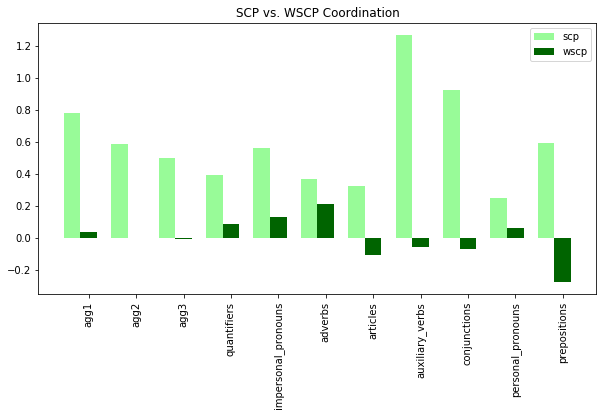

In [15]:
data = (scp_all, wscp_all)
labels = ['scp', 'wscp']
colors = ['violet', 'palegreen']
title = 'SCP vs. WSCP Coordination'
items = ['agg1', 'agg2', 'agg3'] + markers_list

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(10,5))
ind = np.arange(len(items))
width = 0.35
    
p = []
for i, d in enumerate(data):
    values = [d.mean(level=0).loc[True].loc[m] * 100 for m in items]
    p.append(ax.bar(ind+i*width, list(values), width=width, color=c[i]))
ax.legend((p[i][0] for i in range(len(p))), labels)
ax.set_title(title)
ax.set_xticklabels(items)
ax.set_xticks(ind+width)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

Measured with WSCP, articles, auxillary verbs, conjunctions, and prepositions exhibit negative coordination i.e., presence of a marker `m` from one of those categories in `post_a` makes it **less likely** (than `user_b`'s baseline) that any given word in `post_b`'s utterance exhibits `m`.

Nevertheless, the post-level SCP measure for these markers is positive (especially so for auxiliary verbs and conjnuctions. That means that presence of `m` in `post_a` makes it **more likely** (than than `user_b`'s baseline) that `post_b` contains at least one marker in `m`.

*Note that although the baselines for SCP and WSCP are defined slightly differently, they are the same when considering `groupA = 'all_users'`.*

Unless I am mistaken, the only explaination for the discrepancy is posts where: 
1. `post_a` exhibits `m` **and**
2. `post_b` exhibits `m` **but**
3. `post_b` exhibits *fewer* `m`-tokens than would be predicted by `b`'s baseline frequency.

Let's look for some posts like that.

### Auxiliary Verbs

These are the auxiliary verbs we have as markers

In [16]:
print('; '.join([mi for m in markers['auxiliary_verbs'] for mi in m]))

be; is; are; were; was; been; am; being; have; has; was; were; would; will; do; can; could; dare; does; did; had; having; may; might; must; need; ought; shall; should; 'll; 'd


In [17]:
if 'baseline_b' in df:
    df = df.drop('baseline_b', 1) # temp column for this analysis

In [18]:
def base_prob_m(m):
    base_m_count = posts.groupby('user')[m].sum()
    base_word_count = posts.groupby('user')['length'].sum()
    base_prob = base_m_count / base_word_count
    return base_prob

m = 'auxiliary_verbs'
ma_bin = df[m+'_a'] > 0 # condition 1
mb_bin = df[m+'_b'] > 0 # condition 2

baselines = base_prob_m(m)
baselines.name = 'baseline_b'
baselines.index.name = 'user_b'
df = df.join(baselines, on='user_b')
mb_freq = df[m+'_b'] / df['length_b']
mb_cond = mb_freq < df['baseline_b'] # condition_3

In [19]:
print(len(df[ma_bin & mb_bin]))
print(len(df[ma_bin & mb_bin & mb_cond]))

157536
68795


Almost half (%47) of the reply pairs where `post_a` and `post_b` exhibited `m` also have fewer `m`-tokens than expected.

In [20]:
print(len(df))
print(len(df[mb_cond]))

224836
122176


To compare, %54 of all reply pairs have fewer `m`-tokens than expected. Why is it not exactly %50? Must have something to do with shorter messages tending not to contain auxillary verbs...

Regardless, it does seem that when `a` and `b` both use `m`, more postss have `m` than would be expected from the baseline.

WSCP is an average of the observed frequency of `m`-tokens when `post_a` uses `m` minus `user_b`'s baseline frequency. Thus the posts from this group (satisfying conditions 1,2 and 3) that contribute the most to negative alignment are those where the `m`-frequency is much lower than the baseline 

In [21]:
df['wscp_contribution'] = mb_freq - df['baseline_b'] 
df_all3 = df[ma_bin & mb_bin & mb_cond]
df_all3 = df_all3.sort_values('wscp_contribution')

In [22]:
for i, row in df_all3.head(20).iterrows():
    print()
    print("====== Post a: ======= ({} tokens, {} auxiliary verbs)".format(row.length_a, row.auxiliary_verbs_a))
    print(row.clean_text_a)
    print()
    print("====== Post b: ======= ({} tokens, {} auxiliary verbs)".format(row.length_b, row.auxiliary_verbs_b))
    print(row.clean_text_b)
    print("======================")
    print("user_b: {}".format(row.user_b))
    print("user_b baseline:   {}".format(row.baseline_b))
    print("post_b frequency:  {}".format(row.auxiliary_verbs_b / row.length_b))
    print("WSCP Contribution: {} (frequency - baseline)".format(row.wscp_contribution))

    print("======================")
    print()


====== Post a: ======= (109 tokens, 8 auxiliary verbs)
(after multipled edit conflicts)I checked your behaviour and your contributions myself at the time, as did numerous other admins who reviewed your edits and the block and it was subject of extensive discussion on and off-site so your suggestion that I should have checked with others is silly. You violated Wikipedia's policies and were blocked rightly for it; you've been given a second chance and instead of being productive you come here to moan about a comment I made more than six months ago, that I still stand by, and to pursue your now year-old vendetta against Nick? 

====== Post b: ======= (43 tokens, 1 auxiliary verbs)
I am not trying to spamming all the administrators and editors who participated in the discussion more than six months ago. I just posted messages on your talk page and the talk page of [[User:Philippe\u200e]]. 
user_b: RS1900
user_b baseline:   0.11224489795918367
post_b frequency:  0.023255813953488372
WSCP C

It seems that the negative WSCP contribution of these posts may be explained by exceptionally high `user_b` baselines for auxiliary verbs, rather than low `post_b` frequencies.

count    224836.000000
mean          0.065823
std           0.014059
min           0.000000
25%           0.058594
50%           0.066118
75%           0.073620
max           0.333333
Name: baseline_b, dtype: float64
count    68795.000000
mean         0.067495
std          0.012397
min          0.007391
25%          0.060364
50%          0.067233
75%          0.074723
max          0.205882
Name: baseline_b, dtype: float64


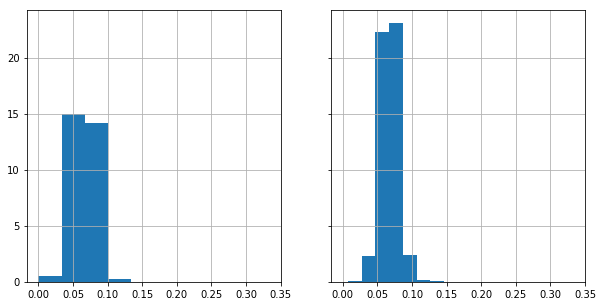

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
ax1.set_title = "user_b baselines (Aux. Verbs)"
ax2.set_title = "post_b baselines in negative WSCP pairs"
df.baseline_b.hist(ax=ax1, density=True)
df_all3.baseline_b.hist(ax=ax2, density=True)
print(df.baseline_b.describe())
print(df_all3.baseline_b.describe())

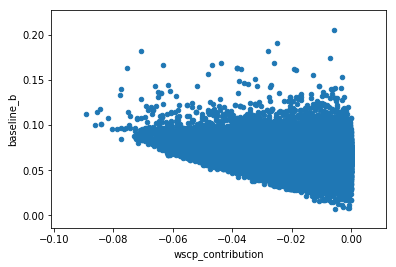

In [24]:
df_all3.plot.scatter('wscp_contribution', 'baseline_b')

Let's look more closely the users who appear most often in the negative WSCP-contributing posts.

Although the statistics of user baselines in negative WSCP-contributing posts aren't too much different overall, it seems the baseline aux rates are much higher in the top negative contributing posts.

In [25]:
df_all3.head(1000).groupby(['user_b', 'baseline_b']).size().sort_values(ascending=False).head(10)

user_b         baseline_b
Mattisse       0.084818      35
MONGO          0.084387      27
Carcharoth     0.077177      16
Vegaswikian    0.097205      13
Awadewit       0.082732      11
Mike Christie  0.074143       8
Tango          0.089159       7
The JPS        0.076975       6
Kungfuadam     0.081027       6
Kumioko        0.079307       6
dtype: int64

In [35]:
len(df_all3)

83914

In [38]:
df_all3.user_b.value_counts().describe()

count    11396.000000
mean         7.363461
std         22.886673
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        777.000000
Name: user_b, dtype: float64

First, a sanity check.

In [26]:
u_posts = posts[posts.user == 'Vegaswikian']
total_posts = len(u_posts)
total_tokens = u_posts.length.sum()
total_m_tokens = u_posts.auxiliary_verbs.sum()
print("Used {} aux verbs out of {} tokens in {} posts".format(total_m_tokens, total_tokens, total_posts))
print("Baseline aux verb usage is {}".format(total_m_tokens / total_tokens))
print("Previously computed: {}".format(baselines['Vegaswikian']))

Used 2198 aux verbs out of 22612 tokens in 326 posts
Baseline aux verb usage is 0.09720502388112506
Previously computed: 0.09720502388112506


In [27]:
u_posts = posts[posts.user == 'Mattisse']
top_aux_rates = (u_posts.auxiliary_verbs / u_posts.length).sort_values(ascending=False).head(40)

for i in top_aux_rates.index:
    post = posts.loc[i]
    print("Tokens: {}, Aux verbs: {}, Rate: {}".format(post.length, post.auxiliary_verbs, post.auxiliary_verbs / post.length))
    print(post.clean_text)
    print()

Tokens: 7, Aux verbs: 2, Rate: 0.2857142857142857
OK. Will do.  &mdash;

Tokens: 8, Aux verbs: 2, Rate: 0.25
Will do! Regards, &mdash;

Tokens: 20, Aux verbs: 5, Rate: 0.25
I will be blocked for quoting my plan? How can that be?  I do not understand.   \u2014

Tokens: 21, Aux verbs: 5, Rate: 0.23809523809523808
I have not been having a good experience on Wikipedia and have been losing interest. Sincerely, &ndash;

Tokens: 21, Aux verbs: 5, Rate: 0.23809523809523808
I am not clear whether there is more that I should do. Is there? Regards, &mdash;

Tokens: 13, Aux verbs: 3, Rate: 0.23076923076923078
O.K. Do that. I will try to do it quickly.  

Tokens: 13, Aux verbs: 3, Rate: 0.23076923076923078
O.K. It would be nice if we could work this out.  

Tokens: 18, Aux verbs: 4, Rate: 0.2222222222222222
Probably I would have to do quite a bit of alteration in wording. Is that O.K?  

Tokens: 23, Aux verbs: 5, Rate: 0.21739130434782608
I think I would be starting trouble if I did that. Could you

In [28]:
u_posts = posts[posts.user == 'MONGO']
top_aux_rates = (u_posts.auxiliary_verbs / u_posts.length).sort_values(ascending=False).head(40)

for i in top_aux_rates.index:
    post = posts.loc[i]
    print("Tokens: {}, Aux verbs: {}, Rate: {}".format(post.length, post.auxiliary_verbs, post.auxiliary_verbs / post.length))
    print(post.clean_text)
    print()

Tokens: 3, Aux verbs: 1, Rate: 0.3333333333333333
Be patient.--

Tokens: 6, Aux verbs: 2, Rate: 0.3333333333333333
What did Rjensen do?--

Tokens: 7, Aux verbs: 2, Rate: 0.2857142857142857
What else would it be?--

Tokens: 7, Aux verbs: 2, Rate: 0.2857142857142857
Yeech...that should be interesting.--

Tokens: 7, Aux verbs: 2, Rate: 0.2857142857142857
Sure, that would be fine.--

Tokens: 12, Aux verbs: 3, Rate: 0.25
It fails notability and may be considered to be advertising anyway.--

Tokens: 12, Aux verbs: 3, Rate: 0.25
Should the article be protected until the issues are resolved?--

Tokens: 16, Aux verbs: 4, Rate: 0.25
He's had recent disputes with you...a neutral admin should have been requested.--

Tokens: 8, Aux verbs: 2, Rate: 0.25
Sure..I'll help as I have time.--

Tokens: 9, Aux verbs: 2, Rate: 0.2222222222222222
Trust me...it is being worked on.--

Tokens: 9, Aux verbs: 2, Rate: 0.2222222222222222
Then he shouldn't be messing with it.--

Tokens: 9, Aux verbs: 2, Rate: 0.2222

In [29]:
u_posts = posts[posts.user == 'Carcharoth']
top_aux_rates = (u_posts.auxiliary_verbs / u_posts.length).sort_values(ascending=False).head(40)

for i in top_aux_rates.index:
    post = posts.loc[i]
    print("Tokens: {}, Aux verbs: {}, Rate: {}".format(post.length, post.auxiliary_verbs, post.auxiliary_verbs / post.length))
    print(post.clean_text)
    print()

Tokens: 8, Aux verbs: 3, Rate: 0.375
I'll see what I can do. 

Tokens: 8, Aux verbs: 3, Rate: 0.375
I'll see what I can do. 

Tokens: 7, Aux verbs: 2, Rate: 0.2857142857142857
Seems to have been sorted now. 

Tokens: 30, Aux verbs: 8, Rate: 0.26666666666666666
This has been resolved now. I am sorry this was not resolved to your satisfaction. I do hope you will take the advice that has been given. 

Tokens: 4, Aux verbs: 1, Rate: 0.25
Will reply there. 

Tokens: 4, Aux verbs: 1, Rate: 0.25
Is this possible? 

Tokens: 8, Aux verbs: 2, Rate: 0.25
Thanks. I'll have a look. 

Tokens: 12, Aux verbs: 3, Rate: 0.25
Did so. Though I see there have been subsequent developments... 

Tokens: 9, Aux verbs: 2, Rate: 0.2222222222222222
Are you sure you have the right person? 

Tokens: 9, Aux verbs: 2, Rate: 0.2222222222222222
I will be looking at this tomorrow night. 

Tokens: 23, Aux verbs: 5, Rate: 0.21739130434782608
No problem. It's good that you can apologise. You'd be surprised how many people 

### Prepositions

Let's look at some examples for prepositions too, since they have the most dramatic negative WSCP.

In [30]:
print('; '.join([mi for m in markers['prepositions'] for mi in m]))

of; in; to; for; with; on; by; at; from; as; into; about; like; after; between; through; over; against; under; without; within; during; before; towards; around; upon; including; among; across; off; behind; since; rather; than; until; according; to; up; to; despite; near; above; per; along; away; from; throughout; outside; round; beyond; worth; down; on; to; up; due; to; inside; plus


In [31]:
if 'baseline_b' in df:
    df = df.drop('baseline_b', 1) # temp column for this analysis

m = 'prepositions'
ma_bin = df[m+'_a'] > 0 # condition 1
mb_bin = df[m+'_b'] > 0 # condition 2

baselines = base_prob_m(m)
baselines.name = 'baseline_b'
baselines.index.name = 'user_b'
df = df.join(baselines, on='user_b')
mb_freq = df[m+'_b'] / df['length_b']
mb_cond = mb_freq < df['baseline_b'] # condition_3

df_all3 = df[ma_bin & mb_bin & mb_cond]

In [32]:
df_all3.head(1000).groupby(['user_b', 'baseline_b']).size().sort_values(ascending=False).head(10)

user_b          baseline_b
Moonriddengirl  0.101059      48
SandyGeorgia    0.099460      36
AnonEMouse      0.089617      31
Cirt            0.090209      29
Awadewit        0.101764      23
Leahtwosaints   0.098004      23
CactusWriter    0.088127      19
Montanabw       0.103857      18
Suede67         0.081334      17
HJ Mitchell     0.100240      17
dtype: int64

In [33]:
u_posts = posts[posts.user == 'Carcharoth']
total_posts = len(u_posts)
total_tokens = u_posts.length.sum()
total_m_tokens = u_posts[m].sum()
print("Used {} {} out of {} tokens in {} posts".format(total_m_tokens, m, total_tokens, total_posts))
print("Baseline aux verb usage is {}".format(total_m_tokens / total_tokens))
print("Previously computed: {}".format(baselines['Vegaswikian']))

Used 13632 prepositions out of 130156 tokens in 1648 posts
Baseline aux verb usage is 0.10473585543501644
Previously computed: 0.1092782593313285


In [34]:
u_posts = posts[posts.user == 'Carcharoth']
top_aux_rates = (u_posts[m] / u_posts.length).sort_values(ascending=False).head(40)

for i in top_aux_rates.index:
    post = posts.loc[i]
    print("Tokens: {}, Aux verbs: {}, Rate: {}".format(post.length, post[m], post[m] / post.length))
    print(post.clean_text)
    print()

Tokens: 9, Aux verbs: 3, Rate: 0.3333333333333333
Er, up to you, I suppose. 

Tokens: 11, Aux verbs: 3, Rate: 0.2727272727272727
Is this a response to Jehochman in the section above? 

Tokens: 50, Aux verbs: 13, Rate: 0.26
And thanks for this as well. With some of the opinions flying around, I was kind of hesitant to ask, but the responses from both of you have (in a good way) restored some of my faith in things around here. :-) 

Tokens: 4, Aux verbs: 1, Rate: 0.25
Commented over there. 

Tokens: 12, Aux verbs: 3, Rate: 0.25
Give me a day or two to get round to this. 

Tokens: 4, Aux verbs: 1, Rate: 0.25
Replied over there. 

Tokens: 4, Aux verbs: 1, Rate: 0.25
replied over there. 

Tokens: 4, Aux verbs: 1, Rate: 0.25
Replied over there. 

Tokens: 4, Aux verbs: 1, Rate: 0.25
Commented over there. 

Tokens: 4, Aux verbs: 1, Rate: 0.25
Replied over there. 

Tokens: 24, Aux verbs: 6, Rate: 0.25
As I said, I have to move on to deal with other things now, but I hope this addresses your con

Based on these posts, it seems that the high auxiliary verb and preposition rates are a real phenomenon, perhaps indicitive of a particular speech style, but not created by some artificat.